# General variables and libraries
Run this cell first

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statannot import add_stat_annotation
import colorcet as cc
import matplotlib.patches as mpatches

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#VARIABLES
BIG = '/home/meco/Big_data/RUSITEC/Annotated_MAGs/'
TABS = 'Data/MTables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
DOMS = ['Archaea', 'Bacteria']

ALPHAS = {
    'shannon': 'Shannon index', 
    'observed_features': 'Observed features',
    'evenness': 'Pielou\'s evenness'}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF', 
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

BETAS = {
    'aitchison': 'Aitchison', 
    'bray_curtis': 'Bray-Curtis'}

MDICT = {
    'RF': 'd', 'RSP': 's', 
    'E': '^', 
    'FL': 'p', 
    'FR': 'X'}

CDICT = {'TMR': 'grey',
         'AN1': 'limegreen',
         'AN2': 'green',
         'AT': 'red',
         'FV1': 'deepskyblue',
         'FV2': 'blue',
         'NoT': 'whitesmoke'}

!mkdir -p $TABS

# Install dependencies

In [10]:
!pip install deicode
!qiime dev refresh-cache

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.


In [31]:
!conda install -y -c conda-forge statannot

Retrieving notices: ...working... done
Solving environment: | ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [ ]:
!pip install colorcet

# Edit metadata file

In [55]:
names = {
    'Trt1': 'TMR',
    'Trt2': 'AN1',
    'Trt3': 'AN2',
    'Trt4': 'AT',
    'Trt5': 'FV1',
    'Trt6': 'FV2',
    'not_appl':'NoT'}

META['Trt'] = META.Treatment.map(names)
META.to_csv('metadata.tsv', sep='\t')

## Barplots

In [10]:
# taxonomies GTDB
arc = pd.read_csv(f'Data/gtdbtk.ar53.summary.tsv', sep='\t', index_col=0)
bac = pd.read_csv(f'Data/gtdbtk.bac120.summary.tsv', sep='\t', index_col=0)
gtdb = pd.concat([arc, bac])
gtdb.index = gtdb.index.str.replace('mOTU', 'MAG').str.strip('_assembly')
gtdb.to_csv('Data/MAGs_gtdb_taxa.tsv', sep='\t')

In [17]:
#merge taxonomes from SM and GTDB
gtdb = pd.read_csv('Data/MAGs_gtdb_taxa.tsv', sep='\t', index_col=0)
bins = pd.read_csv(f'Data/18.Annotated_MAGs.bintable', sep='\t', index_col=0, skiprows=1)
bins.index = bins.index.str.replace('mOTU', 'MAG')
taxa = bins[['Tax']].copy()
taxa['GTDB'] = gtdb['classification']
taxa['Taxon'] = taxa['GTDB']
taxa.sort_index(inplace=True)
bins.sort_index(inplace=True)
bins.to_csv(f'{TABS}/bintable.tsv', sep='\t')
#taxa.to_csv('Data/MAGs_taxonomy.tsv', sep='\t')

### #further manual curation###

In [2]:
taxa = pd.read_csv('Data/MAGs_taxonomy.tsv', sep='\t', index_col=0)
bins = pd.read_csv(f'{TABS}/bintable.tsv', sep='\t', index_col=0)
bins = bins.loc[(bins.Completeness >= 90) & (bins.Contamination <= 5)]
bins['Taxon'] = taxa.Taxon.str.split('__').str[-1]
bins.index = 'rstc' + bins.index + ' ' + bins.Taxon
tpm = bins[[c for c in bins.columns if c.startswith('TPM ')]].copy()
tpm.columns = [c.replace('TPM ', 's') for c in tpm.columns]
tpm.to_csv(f'{TABS}/bintable_tpm.tsv', sep='\t')
cov = bins[[c for c in bins.columns if c.startswith('Coverage ')]].copy()
cov.columns = [c.replace('Coverage ', 's') for c in cov.columns]
cov['GC'] = bins['GC perc']
cov.to_csv(f'{TABS}/bintable_cov.tsv', sep='\t')

### Taxabarplots by BS

mkdir: cannot create directory ‘Figures/Taxabarplots’: File exists


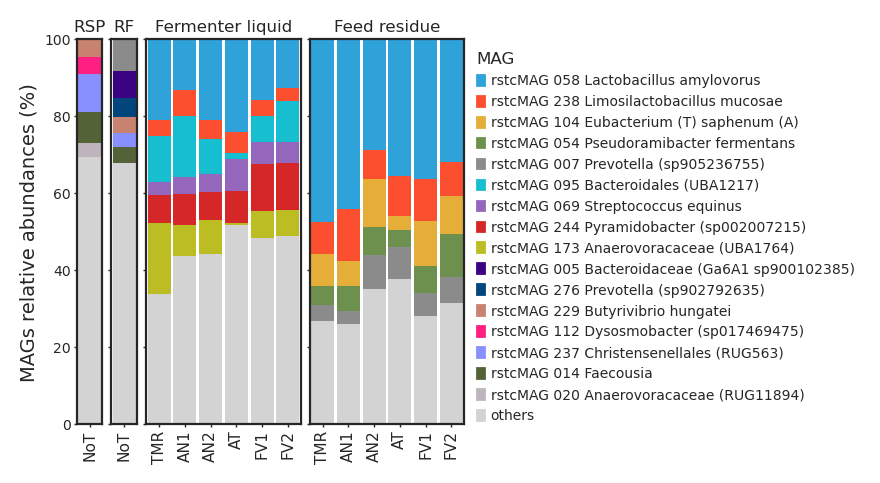

In [7]:
!mkdir Figures/Taxabarplots

colours = cc.glasbey_hv
del colours[26] #remove white color

#figure
ratios = [len(META.loc[META.BS==st].Trt.unique()) for st in STYPES]
fig, axes = plt.subplots(1, len(STYPES), figsize=(2.5, 2.5), sharey='row', sharex='col',
                         gridspec_kw={'wspace': .1, 'hspace': .04, 'width_ratios':ratios})
#axs, i = [[r, c] for r in range(2) for c in range(len(STYPES))], 0
    
df = pd.read_csv(f'{TABS}/bintable_tpm.tsv', sep='\t', index_col=0).T
df = df[[col for col in df.columns if 'rstcMAG_' in col]]
meta = META.loc[df.index].copy()
df = df.groupby(level=0, axis=1).sum() #sum duplicates
df.loc['mean'] = df.mean() #add a row with mean 
df.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
df.drop(inplace=True, index='mean')
df = df.div(df.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
df.columns = [c.replace('_', ' ') for c in df.columns]
#df.columns = [c.split('s__')[-1].replace('_', ' ') for c in df.columns]

#define colors
cdict = dict(zip(df.columns.tolist()[::-1], colours))

#legend
legend = []

#by BS
for i, st in enumerate(STYPES):
    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    md = meta.loc[meta.BS == st].copy()
    data = df.loc[md.index].copy()
    data.to_csv(f'Results/Taxabarplots/relative-{st}.tsv', sep='\t')

    #mean rel abund by diets
    data['Trt'] = md.Trt
    data.set_index('Trt', inplace=True)
    data = data.groupby(level='Trt').mean()
    data = data.reindex([trt for trt in CDICT if trt in data.index])
    data.to_csv(f'Results/Taxabarplots/relative-by-BS-{st}.tsv', sep='\t')       

    #plot
    for col in data.columns.tolist(): #remove low abundant features 
        if data[col].mean() < 3.5: 
            data = data.drop(col, axis=1)

    bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
    ax.bar(x=data.index, height=bottom, color='lightgrey', label=col, width=0.9, linewidth=.0)
    for col in data.columns: #iterate through all features
        c = cdict[col] #define color
        if col not in legend: 
            legend = [col] + legend #add color to legend
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, 
               width=0.9, linewidth=.0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom

    #aesthetics
    ax.tick_params(axis='both', labelsize=5, pad=1, length=1, width=0.5) #adjust ticks
    ax.tick_params(axis='x', labelsize=5.5, labelrotation=90) #adjust ticks
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    if st == list(STYPES.keys())[0]:
        ax.set_ylabel(f'MAGs relative abundances (%)', fontsize=7, labelpad=2)
    ax.text(.5, 1.02, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)

    #legend
    if st == list(STYPES.keys())[-1]:
        labels = [l for l in df.columns[::-1] if l in legend] + ['others']                     
        handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
                  else mpatches.Patch(color=cdict[l], label=l) for l in labels]

        leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1), fontsize=5, frameon=False,
                        handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes, 
                        title='MAG', title_fontsize=6)  
        leg._legend_box.align = "left"
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig(f'Figures/Taxabarplots/MAGs-taxabarplot_BS.png', bbox_inches='tight', facecolor='w')